In [1]:
from pathlib import Path

import numpy as np
import tensorflow.compat.v1 as tf

from contact_graspnet.orig.contact_graspnet import config_utils
from contact_graspnet.orig.contact_graspnet.data import load_available_input_data
from contact_graspnet.orig.contact_graspnet.contact_grasp_estimator import GraspEstimator
from contact_graspnet.orig.contact_graspnet.visualization_utils import visualize_grasps, show_image

2023-02-19 16:03:18.080940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 16:03:19.322338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moritz/catkin_ws/devel/lib:/opt/ros/noetic/lib:/home/moritz/.mujoco/mujoco210/bin:/home/moritz/mambaforge/envs/contact/lib/:/home/moritz/mambaforge/envs/contact/lib/
2023-02-19 16:03:19.322449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No

/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/orig/pointnet2/tf_ops/sampling


In [2]:

tf.disable_eager_execution()
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-02-19 16:03:25.555005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 16:03:25.578030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 16:03:25.578611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
checkpoint_dir = Path.cwd().parent / "contact_graspnet" / "checkpoints" / "scene_test_2048_bs3_hor_sigma_001"
input_path = Path.cwd().parent / "contact_graspnet" / "data" / "raw" / "orig_test_data" / "7.npy"

In [4]:
# this basically loads the config.yaml file in the checkpoint directory
# we overwrite the batch_size with 1
global_config = config_utils.load_config(checkpoint_dir, batch_size=1)

/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/orig/contact_graspnet/config_utils.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  global_config = yaml.load(f)


In [5]:
# build the model. In this implementation, the model is a wrapper around the 
# network itself and also contains preprocessing and postprocessing steps
# and different utility methods
grasp_estimator = GraspEstimator(global_config)
grasp_estimator.build_network()

/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/orig/pointnet2/utils/tf_util.py:571: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  momentum=bn_decay, axis=axis, name=scope,


--- Get model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


{'pointclouds_pl': <tf.Tensor 'Placeholder:0' shape=(1, 20000, 3) dtype=float32>,
 'cam_poses_pl': <tf.Tensor 'Placeholder_2:0' shape=(1, 4, 4) dtype=float32>,
 'scene_idx_pl': <tf.Tensor 'Placeholder_1:0' shape=() dtype=int32>,
 'is_training_pl': <tf.Tensor 'Placeholder_3:0' shape=() dtype=bool>,
 'grasp_dir_pred': <tf.Tensor 'l2_normalize:0' shape=(1, 2048, 3) dtype=float32>,
 'binary_seg_head': <tf.Tensor 'fc2_seg/BiasAdd:0' shape=(1, 2048, 1) dtype=float32>,
 'binary_seg_pred': <tf.Tensor 'Sigmoid:0' shape=(1, 2048, 1) dtype=float32>,
 'grasp_offset_head': <tf.Tensor 'fc2_off/BiasAdd:0' shape=(1, 2048, 10) dtype=float32>,
 'grasp_offset_pred': <tf.Tensor 'Sigmoid_1:0' shape=(1, 2048, 10) dtype=float32>,
 'approach_dir_pred': <tf.Tensor 'l2_normalize_1:0' shape=(1, 2048, 3) dtype=float32>,
 'pred_points': <tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
 'offset_pred_idcs_pc': <tf.Tensor 'ArgMax_1:0' shape=(1, 2048) dtype=int64>,
 'offset_bin_pred_vals': <tf.Tens

In [6]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver(save_relative_paths=True)

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

2023-02-19 16:03:32.132782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 16:03:32.133384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 16:03:32.133860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 16:03:32.134239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [7]:
# Load weights
grasp_estimator.load_weights(sess, saver, checkpoint_dir, mode="test")

('loading ', '/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054')
INFO:tensorflow:Restoring parameters from /home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054


2023-02-19 16:03:33.099056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


In [8]:
# this tries to load the input data from the given path and accounts for different
# keys which might be available in the input data
# the example data only contains depth, rgb, segmentation and intrinsics data and no pointcloud
# TODO rewrite this to use own data -> can we simply load the data without any conversions?
segmap, rgb, depth, cam_K, _, _ = load_available_input_data(str(input_path))

# segmap.shape  # (720,1280) 0 - 5
# rgb.shape  # (720,1280,3) 0-255
# depth.shape  # # (720,1280) 0 - 1
# cam_K.shape  # (3,3)
# pc_full # None
# pc_colors # None

In [9]:
# the model works on pointclouds, so we need to extract them from the depth image
# TODO cehck if there is happening any special kind of conversion for which we might account in our data

pc_full, pc_segments, pc_colors = grasp_estimator.extract_point_clouds(
    depth,
    cam_K,
    segmap=segmap,
    rgb=rgb,
    skip_border_objects=False,
    z_range=(0.2, 1.8),
)

# pc_full.shape # (510767, 3)
# pc_colors.shape # (510767, 3)
# pc_segments # Dict[float, np.ndarray]

# for k,v in pc_segments.items():
#     print(k, v.shape)

In [10]:
print(pc_segments.keys())

dict_keys([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])


In [23]:
pred_grasps_cam, scores, contact_pts, gripper_openings = grasp_estimator.predict_scene_grasps(
    sess,
    pc_full,
    pc_segments=pc_segments,
    # local_regions=True,
    filter_grasps=True,
    # forward_passes=1,
)

# pc_segments=None, local_regions = true --> empty dict
# pc_segments=pc_segments, local_regions = true --> dict_keys([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
# pc_segments=pc_segments, local_regions = false --> dict_keys([-1])
# pc_segments=None, local_regions = false --> dict_keys([-1])


print(pred_grasps_cam.keys())
# print(gripper_openings)
# pred_grasps_cam.keys() # (1, 100, 7)

Generated 156 grasps
dict_keys([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])


In [22]:
import mayavi.mlab as mlab

visualize_grasps(
    pc_segments[2],
    {-1: pred_grasps_cam[2]},
    {-1: scores[2]},
    plot_opencv_cam=True,
    # pc_colors=pc_colors,
    gripper_openings={-1: gripper_openings[2]},
)

mlab.show()


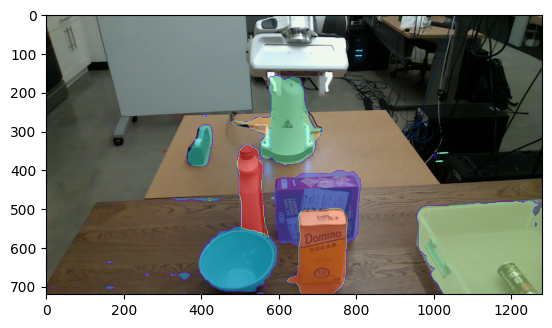

In [15]:
show_image(rgb, segmap)